# Beam search 
Effectue une recherche par faisceau (beam search).

**Args:**
        
- start_state (object): L'état initial de la recherche.
- beam_width (int): La taille du faisceau (nombre de candidats à considérer).
- max_steps (int): Le nombre maximum d'étapes à effectuer.
- get_successors (function): la fonction de voisinage qui retourne les successeurs d'un états (voisins).
- evaluate (function): Une fonction qui prend un état en argument et retourne une valeur d'évaluation.

**Returns:**
- object: Le meilleur état trouvé par la beam search.


In [9]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import heapq
from tqdm import tqdm
from typing import Callable,List,Tuple,Dict

cmap = plt.get_cmap('tab20') # type: ignore
State=Dict[any,int] # type: ignore

# Draw

In [10]:
def draw_graph(G:nx.Graph,state:State,label=False):
        map= [v for _,v in state.items()]
        u=np.unique(map)
        fixed_map=[np.where(u==i)[0][0] for i in map]
        node_cmap = [cmap(v) for v in fixed_map]
        
        pos = nx.spring_layout(G,seed=40)
        # add label too nodes
        if label:
            labels = {node:node for node in G.nodes()}
            nx.draw_networkx_labels(G, pos, labels, font_size=9)
            
        nx.draw(G, pos, node_size = 80, alpha = 0.8, node_color=node_cmap)
        plt.show()

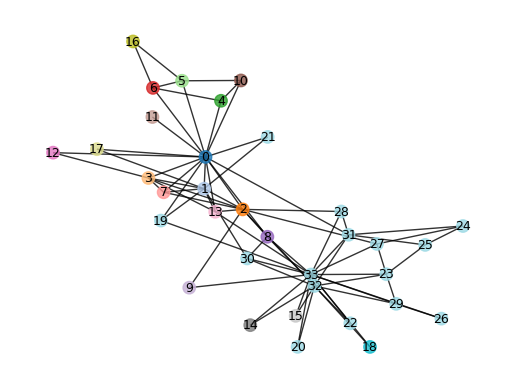

In [11]:
karate_club_graph:nx.Graph = nx.karate_club_graph() # type: ignore
initial_state = {node:i for i,node in enumerate(karate_club_graph.nodes())}
draw_graph(karate_club_graph,initial_state,label=True)

# Utils

In [3]:
def state_partitions(state:State)->List[State]:
    comm_dict = {}
    for node,comm in state.items():
        if comm in comm_dict:
            comm_dict[comm].add(node)
        else:
            comm_dict[comm] = {node}
    return list(comm_dict.values())

In [4]:
def partitions_state(partitions):
    state = {}
    for i,comm in enumerate(partitions):
        for node in comm:
            state[node] = i
    return state

# Initialisation

In [7]:
def init_alea(G:nx.Graph,nb_communities=None)->State:
    if nb_communities is None: nb_communities = len(G.nodes())
    if (nb_communities>len(G.nodes())): raise ValueError("nb_communities must be less than the number of nodes")

    state = {node:np.random.randint(0,nb_communities) for node in G.nodes()}
    return state

In [6]:
def init_greedy(G:nx.Graph)->State:
    partitions= nx.algorithms.community.greedy_modularity_communities(karate_club_graph)
    state=partitions_state(partitions)
    return state

# Fonction de fitness

In [8]:
def modularity(G, state):
    partitions = state_partitions(state)
    return nx.algorithms.community.modularity(G, partitions)

In [32]:
modularity(karate_club_graph, initial_state)

-0.05110473941642772

In [34]:
def coverage(G,state):
    """
    how many nodes in a graph are assigned to a community.
    """
    partitions = state_partitions(state)
    return nx.algorithms.community.quality.partition_quality(G,partitions)[0]

In [34]:
coverage(karate_club_graph, initial_state)

0.0

In [35]:
def performance(G,state):
    """
    measure of how well a community detection algorithm partitions the nodes in 
    a graph into communities that reflect the underlying structure of the graph.
    """
    partitions = state_partitions(state)
    return 1- nx.algorithms.community.quality.partition_quality(G,partitions)[1]

In [65]:
performance(karate_club_graph, initial_state)

0.13903743315508021

In [37]:
partitions = state_partitions(initial_state)
np.array(list(partitions))

array([{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12},
       {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23},
       {24}, {25}, {26}, {27}, {28}, {29}, {30}, {31}, {32}, {33}],
      dtype=object)

In [36]:
def cpm_modularity(G,state, gamma=0.5):
    """
    Calculates the modularity score of a graph using the Constant Potts Model (CPM).

    Parameters:
    - Q (nx.Graph): the graph to calculate the modularity score for.
    - gamma (float): the resolution parameter of the CPM.

    Returns:
    - modularity (float): the modularity score of the graph.
    """
    # Get the adjacency matrix of the graph
    A = nx.to_numpy_array(G)
    n = len(A)

    # Get the total weight of the graph
    m = np.sum(A) / 2

    # Calculate the degree of each node
    ki = np.sum(A, axis=1)

    # Calculate the modularity matrix
    B = A - gamma * np.outer(ki, ki) / (2 * m)

    # Calculate the modularity score
    
    partitions = state_partitions(state)
    ci = np.array(list(partitions))
    modularity = 0
    for c in ci:
        c=np.array(list(c))
        modularity += np.sum(B[np.ix_(c, c)])
    modularity /= (2 * m)

    return modularity

In [39]:
cpm_modularity(karate_club_graph,initial_state,0.5)

-0.02555236970821387

# Exploration du voisinage

In [37]:
def vertex_replacement(G:nx.Graph,state:State)->State:
    to_replace = np.random.choice(list(state.keys()))
    neighbors = list(G.neighbors(to_replace))
    replacement = np.random.choice(neighbors)
    new_state = state.copy()
    new_state[to_replace] = state[replacement]
    if modularity(G,new_state) > modularity(G,state):
        return new_state
        
    return state

In [38]:
new_state = vertex_replacement(karate_club_graph, initial_state)
print(new_state.values())
print(modularity(karate_club_graph, new_state))

dict_values([0, 1, 2, 3, 4, 5, 16, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
-0.03884859729015573


In [39]:
partitions = state_partitions(new_state)
np.array(list(partitions))

array([{0}, {1}, {2}, {3}, {4}, {5}, {16, 6}, {7}, {8}, {9}, {10}, {11},
       {12}, {13}, {14}, {15}, {17}, {18}, {19}, {20}, {21}, {22}, {23},
       {24}, {25}, {26}, {27}, {28}, {29}, {30}, {31}, {32}, {33}],
      dtype=object)

In [40]:
def deplacement(G,state:State):
    # choose random community
    community = np.random.choice(list(set(state.values())))
    # choose random nodes in community
    community_nodes = [node for node in state.keys() if state[node] == community]
    number_of_nodes_to_move = np.random.randint(1,len(community_nodes)+1)
    nodes_to_move = np.random.choice(community_nodes, number_of_nodes_to_move, replace=False)
    # choose random community to move to
    new_community = np.random.choice(list(set(state.values()) - set([community])))
    new_state = state.copy()
    for node in nodes_to_move:
        new_state[node] = new_community
    if modularity(G,new_state) > modularity(G,state):
        return new_state
    return state

In [44]:
new_state = deplacement(karate_club_graph, initial_state)
print(new_state.values())
print(modularity(karate_club_graph, new_state))

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
-0.05110473941642772


In [41]:
def community_fusion(G,state:State):
    # choose random community
    community = np.random.choice(list(set(state.values())))
    # choose random community to fuse with
    new_community = np.random.choice(list(set(state.values()) - set([community])))
    new_state = state.copy()
    for node in new_state.keys():
        if new_state[node] == community:
            new_state[node] = new_community
    if modularity(G,new_state) > modularity(G,state):
        return new_state
    return state

In [46]:
new_state = community_fusion(karate_club_graph, initial_state)
print(new_state.values())
print(modularity(karate_club_graph, new_state))

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 25, 32, 33])
-0.023556530050036537


In [42]:
def exhaustif_cross_mutation(G,history:List[Tuple[float,State]],N:int)->List[Tuple[float,State]]:
    if len(history) < 2:
        return history
    # choose random node
    node = np.random.choice(list(history[-1][1].keys()))
    # get nodes of the same community in every state
    neighbor_communities = []
    for _,state in history:
        comm=state[node]
        nodes_to_cross = [node for node in state.keys() if state[node] == comm]
        neighbor_communities.append(nodes_to_cross)

    states_cross=history.copy()
    for i,(_,state) in enumerate(history):
        for j,neighbor_community in enumerate(neighbor_communities):
            if(i==j):
                continue

            new_state = state.copy()
            for neighbor in neighbor_community:
                new_state[neighbor] = history[j][1][node]
            # check if new state already exists in history
            if(new_state in [state for _,state in states_cross]):
                continue
            mod=modularity(G,new_state)
            candidate = (mod, new_state)
            states_cross.append(candidate)
    
    states_cross=heapq.nlargest(N, states_cross,key=lambda x: x[0])

    return states_cross

In [48]:
history = []
heapq.heappush(history, (modularity(karate_club_graph, initial_state), initial_state))
heapq.heappush(history, (modularity(karate_club_graph, new_state), new_state))
history=heapq.nlargest(2, history)
print(history)

[(-0.023556530050036537, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 25, 32: 32, 33: 33}), (-0.05110473941642772, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33})]


In [49]:
new_history = exhaustif_cross_mutation(karate_club_graph, history, 5)
print(new_history)

[(-0.023556530050036537, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 25, 32: 32, 33: 33}), (-0.05110473941642772, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33})]


In [43]:
def cross_mutation(G:nx.Graph,history:List[Tuple[float,State]],N:int)->List[Tuple[float,State]]:
    if len(history) < 2:
        return history
    # choose random node
    states_cross=history.copy()

    node = np.random.choice(list(history[-1][1].keys()))
    # get two random states in history
    i,j = np.random.choice(range(len(history)), 2, replace=False)
    if i == j:
        return history
        
    state1=history[i][1]
    state2=history[j][1]
    neighbors_1 = [n for n in state1 if state1[n] == state1[node]]
    neighbors_2 = [n for n in state2 if state2[n] == state2[node]]

    new_C2=state2.copy()
    for n in neighbors_1:
        new_C2[n]=state1[node]

    if (not new_C2 in [state for _,state in states_cross]):
        mod=modularity(G,new_C2)
        candidate = (mod, new_C2)
        states_cross.append(candidate)
        states_cross=heapq.nlargest(N, states_cross,key=lambda x: x[0])

    new_C1=state1.copy()
    for n in neighbors_2:
        new_C1[n]=state2[node]

    if (not new_C1 in [state for _,state in states_cross]):
        mod=modularity(G,new_C1)
        candidate = (mod, new_C1)
        states_cross.append(candidate)
        states_cross=heapq.nlargest(N, states_cross,key=lambda x: x[0])

    return states_cross

In [51]:

mod=modularity(karate_club_graph,initial_state)
candidate = (mod, initial_state)
history:List[Tuple[float, State]]=[candidate]
new_state=initial_state
time=0
while(time<1000):
    new_state=vertex_replacement(karate_club_graph,new_state)
    if(not new_state in [state for _,state in history]):
        mod=modularity(karate_club_graph,new_state)
        candidate = (mod, new_state)
        history.append(candidate)
        history=heapq.nlargest(10, history)
    history = cross_mutation(karate_club_graph, history, 10)
    print(len(history),history[0][0])
    time+=1

2 -0.0483499184797886
3 -0.020801709113397418
4 -0.01030715316429601
5 0.0018271771518524917
7 0.009135885759262394
8 0.02152320983489816
8 0.02152320983489816
8 0.02152320983489816
9 0.03377935196117015
10 0.03943891606229269
10 0.03943891606229269
10 0.05067371301137536
10 0.0569423361631154
10 0.07209385131463054
10 0.07209385131463054
10 0.07209385131463054
10 0.07316204718802123
10 0.07631041397275165
10 0.0795712224283653
10 0.0795712224283653
10 0.0795712224283653
10 0.0795712224283653
10 0.08969097280785594
10 0.09430108131406835
10 0.09781488352916927
10 0.09781488352916927
10 0.12995446112329231
10 0.12995446112329231
10 0.12995446112329231
10 0.13355259459155563
10 0.13355259459155563
10 0.13355259459155563
10 0.16880305841344798
10 0.16880305841344798
10 0.17129551545135954
10 0.17129551545135954
10 0.17129551545135954
10 0.17129551545135954
10 0.17129551545135954
10 0.17129551545135954
10 0.17129551545135954
10 0.17129551545135954
10 0.17129551545135954
10 0.17129551545135

In [44]:
class BeamSearch:
    
    G:nx.Graph
    beam:List[Tuple[float,State]]
    best_state:State
    get_successors:Callable[[nx.Graph,State,int],List[Tuple[float,State]]]
    evaluate:Callable[[nx.Graph,State],float]
    beam_width:int
    nb_successors:int

    def __init__(self, G:nx.Graph,start_state:State, get_successors:Callable[[nx.Graph,State,int],List[Tuple[float,State]]], evaluate:Callable[[nx.Graph,State],float], beam_width:int,nb_successors:int):
        """
        Effectue une recherche par faisceau (beam search).

        Args:
            start_state (object): L'état initial de la recherche.
            beam_width (int): La taille du faisceau (nombre de candidats à considérer).
            max_steps (int): Le nombre maximum d'étapes à effectuer.
            get_successors (function): la fonction de voisinage qui retourne les successeurs d'un états (voisins).
            evaluate (function): Une fonction qui prend un état en argument et retourne une valeur d'évaluation.

        Returns:
            object: Le meilleur état trouvé par la beam search.
        """
        self.G = G
        self.beam_width = beam_width
        self.get_successors = get_successors
        self.evaluate = evaluate
        self.beam = [(evaluate(G,start_state), start_state)]
        self.best_state = start_state
        self.nb_successors=nb_successors

    def search(self,max_steps:int):
        for _ in tqdm(range(max_steps)):
            candidates:List[Tuple[float,State]] = []  # Liste pour stocker les nouveaux candidats pour chaque étape
            candidates.extend(self.beam)
            for _, state in self.beam:
                successors = self.get_successors(self.G,state,self.nb_successors)
                # push successors in candidates
                candidates.extend(successors)
                candidates=heapq.nlargest(self.beam_width, candidates,key=lambda x: x[0]) 
            self.beam = heapq.nlargest(self.beam_width, candidates,key=lambda x: x[0])  # Sélectionne les meilleurs candidats, la beam c'est l'ensemble des noeuds accepté dans un niveau.

            if self.evaluate(self.G,self.best_state) < self.beam[0][0]:
                self.best_state = self.beam[0][1]  # Meilleur état trouvé
        
        return self.best_state


In [45]:
voisinage=[vertex_replacement,deplacement,community_fusion]

In [46]:
def get_successors(G:nx.Graph,state:State,N:int)->List[Tuple[float,State]]:
    successors:List[Tuple[float,State]] = []
    for _ in range(N):
        new_state=voisinage[np.random.randint(0,3)](G,state)
        mod=modularity(G,new_state)
        successor=(mod,new_state)
        successors.append(successor)
        
    successors=heapq.nlargest(N, successors,key=lambda x: x[0])
    successors=exhaustif_cross_mutation(G,successors,N)
    return successors

In [78]:
beam=BeamSearch(karate_club_graph,start_state=initial_state,get_successors=get_successors,evaluate=cpm_modularity,beam_width=10,nb_successors=10)

In [50]:
import pandas as pd

fitness = ["CPM" , "Performance","Modularity", "Coverage"]
values = []
initial = [cpm_modularity(karate_club_graph,initial_state), performance(karate_club_graph,initial_state),modularity(karate_club_graph,initial_state),coverage(karate_club_graph,initial_state)]
nmilist = []

beam=BeamSearch(karate_club_graph,start_state=initial_state,get_successors=get_successors,evaluate=cpm_modularity,beam_width=10,nb_successors=10)
result = beam.search(max_steps=300)
values.append(cpm_modularity(karate_club_graph,result))
nmilist .append(test(karate_club_graph,result,"/home/nouss/Desktop/S2/PRJS/DataSets/réels/karate/groundTruth.txt"))

beam=BeamSearch(karate_club_graph,start_state=initial_state,get_successors=get_successors,evaluate=performance,beam_width=10,nb_successors=10)
result = beam.search(max_steps=300)
values.append(performance(karate_club_graph,result))
nmilist .append(test(karate_club_graph,result,"/home/nouss/Desktop/S2/PRJS/DataSets/réels/karate/groundTruth.txt"))

beam=BeamSearch(karate_club_graph,start_state=initial_state,get_successors=get_successors,evaluate=modularity,beam_width=10,nb_successors=10)
result = beam.search(max_steps=300)
values.append(modularity(karate_club_graph,result))
nmilist .append(test(karate_club_graph,result,"/home/nouss/Desktop/S2/PRJS/DataSets/réels/karate/groundTruth.txt"))

beam=BeamSearch(karate_club_graph,start_state=initial_state,get_successors=get_successors,evaluate=coverage,beam_width=10,nb_successors=10)
result = beam.search(max_steps=300)
values.append(coverage(karate_club_graph,result))
nmilist .append(test(karate_club_graph,result,"/home/nouss/Desktop/S2/PRJS/DataSets/réels/karate/groundTruth.txt"))

100%|██████████| 300/300 [00:20<00:00, 14.94it/s]


,fitness,valeur initiale,nouvelle valeur,NMI
0,CPM,-0.025552,0.474719,None
1,Performance,0.139037,0.217469,None
2,Modularity,-0.051105,0.444904,None
3,Coverage,0.000000,0.423077,None


In [51]:
df = pd.DataFrame( {
    "fitness" : fitness,
    "valeur initiale" : initial,
    "nouvelle valeur" : values,
    "NMI" : nmilist
})

df

,fitness,valeur initiale,nouvelle valeur,NMI
0,CPM,-0.025552,0.474719,0.537572
1,Performance,0.139037,0.217469,0.707135
2,Modularity,-0.051105,0.444904,0.687263
3,Coverage,0.000000,0.423077,0.439060


In [21]:
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi

def test(G,p,groundTruthFile):
    with open(groundTruthFile) as f:
        idx = list(G.nodes())
        Gtruth = []
        for i,line in enumerate(f):
            line = line.strip()
            #Gtruth[idx[i]] = line
            Gtruth.append(int(line))
        #compare
    return nmi(Gtruth,list(p.values()))

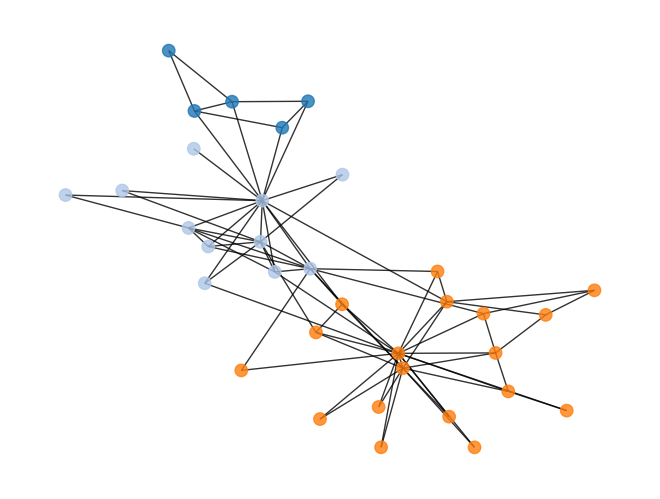

In [58]:
draw_graph(karate_club_graph,result)

In [19]:
beam = []
n = 10
G = karate_club_graph
for i in range(n):
    state = init_alea(G,6)
    beam.append((modularity(G,state),state))

In [17]:
def var(G,beam):
    mod = [ sol[0] for sol in beam]
    mean = sum(mod)/len(beam)
    variance = sum((x - mean) ** 2 for x in mod) / len(mod)
    return variance


In [20]:
var(G,beam)

0.001117621725690219

In [25]:
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi

def similarity(beam):
    nmi_values = []
    n_partitions = len(beam)
    states = [ sol[1] for sol in beam]
    partitions = [list(state.values()) for state in states]

    for i in range(n_partitions):
        for j in range(i + 1, n_partitions):
            nmi_values.append(nmi(partitions[i], partitions[j]))
    return sum(nmi_values) / len(nmi_values)


In [26]:
similarity(beam)

0.24581063238931924